In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

#Description:
The E. coli protein localization prediction task aims to develop machine learning models that accurately predict the subcellular localization of proteins in the bacterium Escherichia coli (E. coli). The task involves classifying proteins into different compartments within the cell, such as the cytoplasm, inner membrane, outer membrane, periplasm, or extracellular space.

#Motivation:
Understanding the subcellular localization of proteins is crucial for deciphering their functions and roles within the cell. In the case of E. coli, accurate prediction of protein localization can provide valuable insights into its cellular processes, metabolic pathways, and interactions with the environment. By identifying the specific compartments where proteins are localized, researchers can gain a better understanding of their functions, potential interactions, and involvement in various biological processes.

Machine learning models trained on protein sequence and other relevant features can assist in predicting protein localization accurately and efficiently. These predictions can aid in the annotation of newly sequenced proteins, guide experimental studies, and contribute to the understanding of the complex cellular machinery of E. coli.

The E. coli protein localization prediction task poses challenges such as dealing with high-dimensional protein sequence data, handling class imbalance, capturing sequence motifs relevant to localization, and exploring the relationships between sequence features and subcellular compartments. By developing robust machine learning models, researchers can enhance our understanding of E. coli biology and contribute to advancements in bioinformatics, functional genomics, and drug discovery efforts.

# Data
Attribute Information:

1. Sequence Name: Accession number for the SWISS-PROT database
2. mcg: McGeoch's method for signal sequence recognition.
3. gvh: von Heijne's method for signal sequence recognition.
4. lip: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute.
5. chg: Presence of charge on N-terminus of predicted lipoproteins. Binary attribute.
6. aac: score of discriminant analysis of the amino acid content of outer membrane and periplasmic proteins.
7. alm1: score of the ALOM membrane spanning region prediction program.
8. alm2: score of ALOM program after excluding putative cleavable signal regions from the sequence.

Site information:
```
  cp  (cytoplasm)                                    143
  im  (inner membrane without signal sequence)        77               
  pp  (perisplasm)                                    52
  imU (inner membrane, uncleavable signal sequence)   35
  om  (outer membrane)                                20
  omL (outer membrane lipoprotein)                     5
  imL (inner membrane lipoprotein)                     2
  imS (inner membrane, cleavable signal sequence)      2

  ```

Source: https://archive.ics.uci.edu/ml/datasets/ecoli

In [3]:
df = pd.read_csv("ecoli.csv", delim_whitespace=True)

# Assign names to Columns
df.columns = ['seq_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'site']

df = df.drop(columns="seq_name")

# Exploratory Data Analysis and Visualization
Exploring if the dataset has any missing data points and creating a statistical summary of the numerical features.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     335 non-null    float64
 1   gvh     335 non-null    float64
 2   lip     335 non-null    float64
 3   chg     335 non-null    float64
 4   aac     335 non-null    float64
 5   alm1    335 non-null    float64
 6   alm2    335 non-null    float64
 7   site    335 non-null    object 
dtypes: float64(7), object(1)
memory usage: 21.1+ KB


 We can see that we are dealing with an imbalanced classification task.

In [5]:
df['site'].value_counts()

cp     142
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: site, dtype: int64

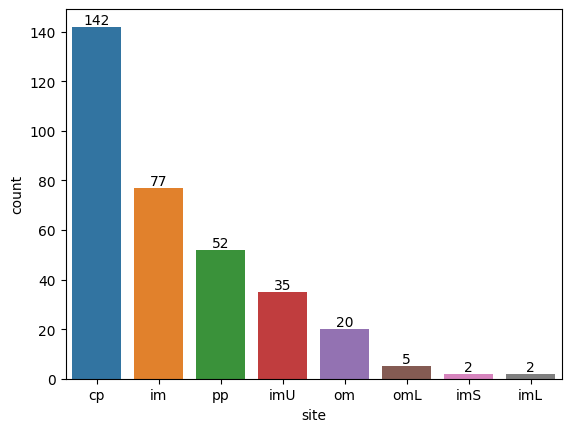

In [6]:
# Calculate the value counts and sort the values
site_counts = df['site'].value_counts().sort_values(ascending=False)

# Create the countplot with the specified order
ax = sns.countplot(x=df['site'], order=site_counts.index)

# Add labels to the bars
ax.bar_label(ax.containers[0])

# Display the plot
plt.show()

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mcg,335.0,0.500090,0.194924,0.00,0.34,0.50,0.665,0.89
gvh,335.0,0.500627,0.147932,0.16,0.40,0.47,0.570,1.00
lip,335.0,0.495522,0.088624,0.48,0.48,0.48,0.480,1.00
chg,335.0,0.501493,0.027318,0.50,0.50,0.50,0.500,1.00
aac,335.0,0.499851,0.122515,0.00,0.42,0.49,0.570,0.88
alm1,335.0,0.500955,0.215603,0.03,0.33,0.46,0.710,1.00
alm2,335.0,0.500179,0.209563,0.00,0.35,0.43,0.710,0.99


The site column is categorical, and it would be helpful to see how the numerical variables vary by site. For this, we can use boxplots. <br>
We see that: <br>
- chg is highest in site imL
- aac is highest in site om
- alm1 is highest for site im
- gvh is lowest for site cp
- mcg is lowest for site cp
- site pp seems to be pretty average

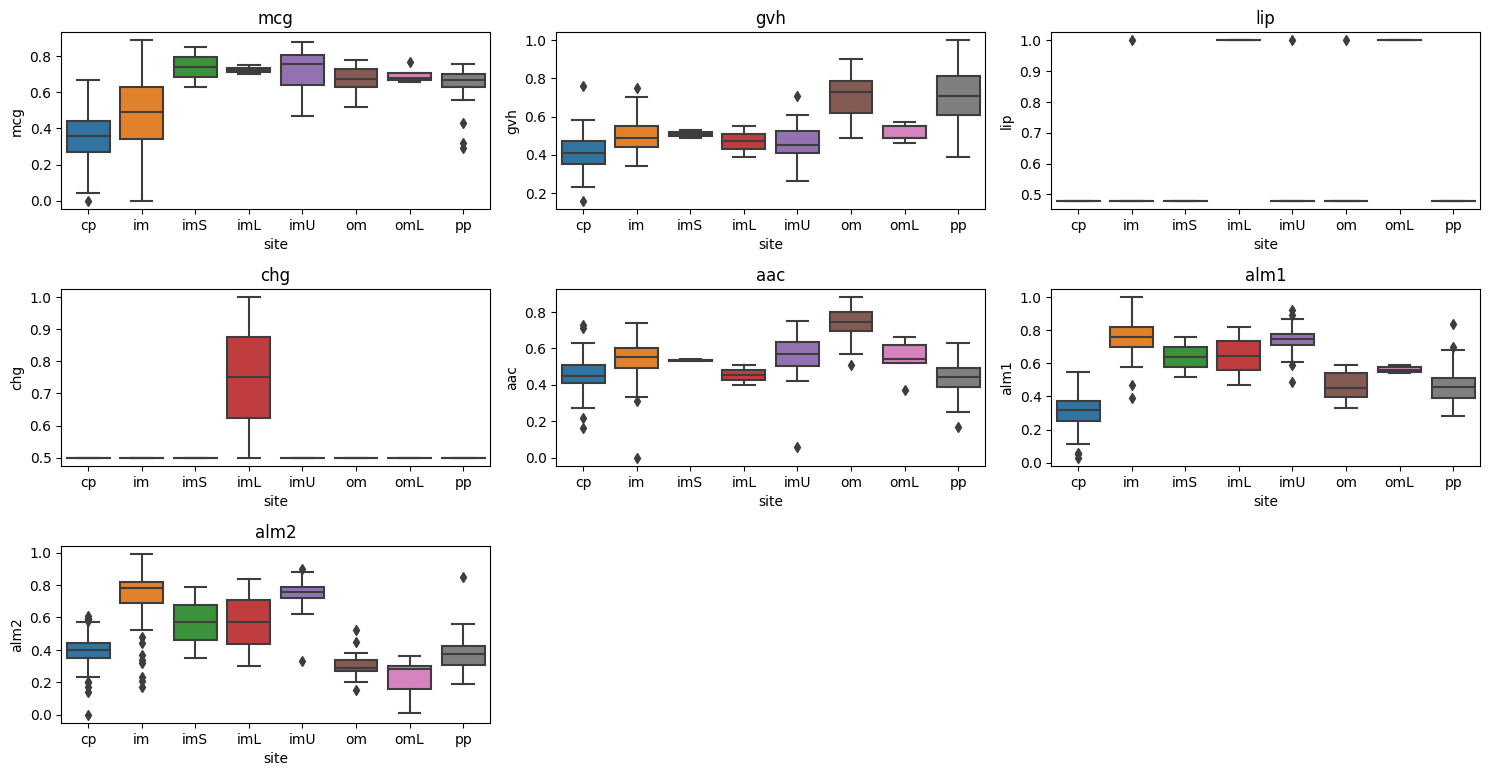

In [8]:
c = 0
plt.figure(figsize=(15,10))
for i in df.columns[:-1]:
  c = c + 1
  plt.subplot(4,3, c)
  plt.title(i)
  sns.boxplot(x='site', y=i, data=df)
plt.tight_layout()
plt.show()

In [9]:
le = preprocessing.LabelEncoder()
df["site"] = le.fit_transform(df['site'])
df

,mcg,gvh,lip,chg,aac,alm1,alm2,site
0,0.07,0.40,0.48,0.5,0.54,0.35,0.44,0
1,0.56,0.40,0.48,0.5,0.49,0.37,0.46,0
2,0.59,0.49,0.48,0.5,0.52,0.45,0.36,0
3,0.23,0.32,0.48,0.5,0.55,0.25,0.35,0
4,0.67,0.39,0.48,0.5,0.36,0.38,0.46,0
...,...,...,...,...,...,...,...,...
330,0.74,0.56,0.48,0.5,0.47,0.68,0.30,7
331,0.71,0.57,0.48,0.5,0.48,0.35,0.32,7
332,0.61,0.60,0.48,0.5,0.44,0.39,0.38,7
333,0.59,0.61,0.48,0.5,0.42,0.42,0.37,7


In [10]:
le.classes_

array(['cp', 'im', 'imL', 'imS', 'imU', 'om', 'omL', 'pp'], dtype=object)

In [11]:
X = df.drop(columns='site')
y = df['site']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
svc_model = SVC()
nb_model = GaussianNB()
gb_model = GradientBoostingClassifier()

# Setting up model training

Since dataset is imbalanced, we will use weighted f1 scoring.

In [52]:
# SVC Model
C = np.logspace(-4, 4, 10)
kernel = ["poly", 'rbf', 'sigmoid', 'linear']
degree = [1,2,3,4]

svc_param_grid = {"C": C,
                  "kernel": kernel,
                  "degree": degree,
                  'probability': [True]}

svc_grid_model = GridSearchCV(svc_model, param_grid=svc_param_grid, cv=2, scoring='f1_weighted')
svc_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'degree': [1, 2, 3, 4],
                         'kernel': ['rbf', 'sigmoid', 'linear'],
                         'probability': [True]},
             scoring='f1_weighted')

In [32]:
# NB Model
var_smoothing = np.linspace(1e-10, 1e-8, 10)

nb_param_grid = {"var_smoothing":var_smoothing}

nb_grid_model = GridSearchCV(nb_model, param_grid=nb_param_grid, cv=2, scoring="f1_weighted")
nb_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.0e-10, 1.2e-09, 2.3e-09, 3.4e-09, 4.5e-09, 5.6e-09, 6.7e-09,
       7.8e-09, 8.9e-09, 1.0e-08])},
             scoring='f1_weighted')

In [35]:
# GB Model
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [100, 120],
    'max_depth': [3, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 3]
}

gb_grid_model = GridSearchCV(gb_model, param_grid=param_grid, cv=2, scoring="f1_weighted")

# Fit the model to the data
gb_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'max_depth': [3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 120]},
             scoring='f1_weighted')

In [36]:
svc_grid_model.best_estimator_

SVC(C=2.782559402207126, degree=1, kernel='poly', probability=True)

In [37]:
nb_grid_model.best_estimator_

GaussianNB(var_smoothing=1.2000000000000002e-09)

In [38]:
gb_grid_model.best_estimator_

GradientBoostingClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=4)

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.75      0.86         8
           4       0.67      1.00      0.80         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5

    accuracy                           0.94        34
   macro avg       0.94      0.96      0.94        34
weighted avg       0.96      0.94      0.94        34



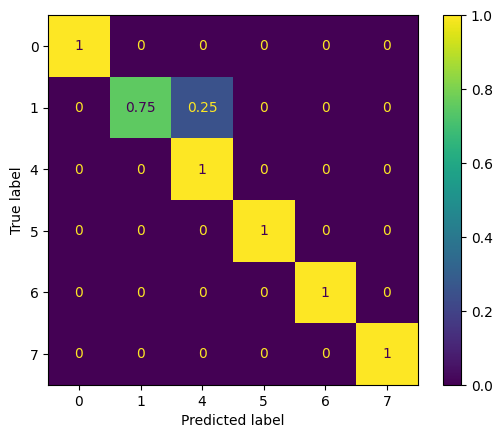

In [43]:
y_pred = svc_grid_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true");

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.75      0.86         8
           4       0.80      1.00      0.89         4
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         1
           7       0.71      1.00      0.83         5

    accuracy                           0.91        34
   macro avg       0.92      0.88      0.87        34
weighted avg       0.93      0.91      0.91        34



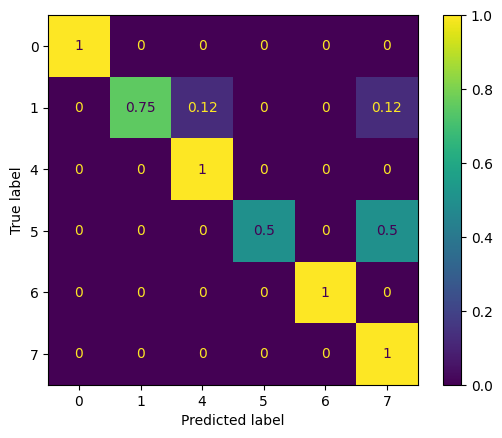

In [44]:
y_pred = nb_grid_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true");

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       1.00      0.88      0.93         8
           4       0.80      1.00      0.89         4
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       0.80      0.80      0.80         5

    accuracy                           0.88        34
   macro avg       0.86      0.92      0.89        34
weighted avg       0.90      0.88      0.88        34



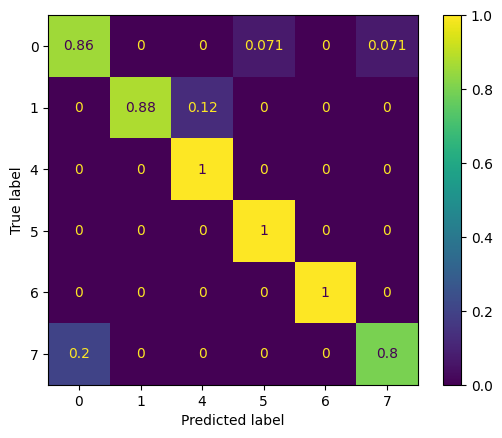

In [45]:
y_pred = gb_grid_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true");

# NOTE:

For our best performing model (SVC), since the kernel "poly" was chosen with degree of 1, this is the same as a linear kernel. To interpret the coefficients, I retrained with linear kernel.

In [ ]:
# SVC Model 2
C = np.logspace(-4, 4, 10)
kernel = ['linear']
degree = [1,2,3,4]

svc_param_grid = {"C": C,
                  "kernel": kernel,
                  "degree": degree,
                  'probability': [True]}

svc_grid_model_2 = GridSearchCV(svc_model, param_grid=svc_param_grid, cv=2, scoring='f1_weighted')
svc_grid_model_2.fit(X_train_scaled, y_train)

In [53]:
svc_grid_model_2.best_estimator_

SVC(C=2.782559402207126, degree=1, kernel='linear', probability=True)

# Final model and interpretation

Our model performed extremely well, achieving a weighted f1 score of 94%. It only missclassified 2 protein examples of imU (inner membrane, uncleavable signal sequence) as im  (inner membrane without signal sequence). This makes sense as these are both located in the inner membrane. Furthermore, it also performed well on the less represented classes. We can see that the most important features within this dataset to predict protein localization in E. coli were alm1, gvh, and mcg. Just from looking at the boxplots, this may not have been obvious.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.75      0.86         8
           4       0.67      1.00      0.80         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5

    accuracy                           0.94        34
   macro avg       0.94      0.96      0.94        34
weighted avg       0.96      0.94      0.94        34



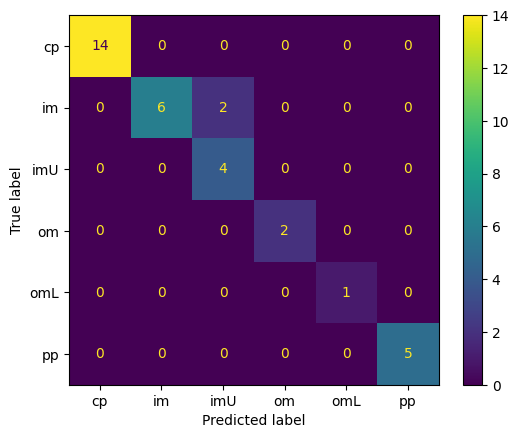

In [80]:
y_pred = svc_grid_model_2.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred));

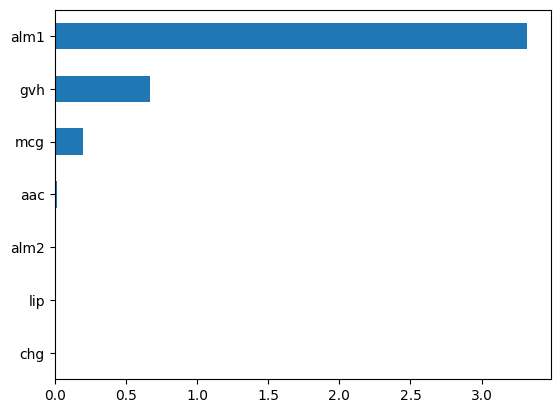

In [81]:
pd.Series(abs(svc_grid_model_2.best_estimator_.coef_[0]), index=X.columns).sort_values().plot(kind='barh');